In [1]:
import numpy as np
import cv2
from PIL import Image,ImageSequence
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from matplotlib.patches import Ellipse
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import random
import pims
import trackpy as tp
import os
from scipy import stats
from scipy.optimize import curve_fit
import clickpoints
from shapely.geometry import Polygon

import helper_functions as hp

# calibration using bubbles

In [ ]:
#test examples

#new camera 50kPa
#path = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_19_12_07_33.tif'
#path = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_25_12_34_14.tif'
#path = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_25_12_34_59.tif'

#new camera 65kPa
#path = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\65kPa\2022_07_25_12_35_34.tif'
#path = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\65kPa\2022_07_25_12_36_14.tif'
#path = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\65kPa\2022_07_25_12_36_54.tif'

#new camera 80kPa
#path = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\80kPa\2022_07_25_12_38_47.tif'
path = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\80kPa\2022_07_25_12_40_38.tif'
#path = r'‪\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\80kPa\2022_07_25_12_41_30.tif'



#to avoid errors which may or may not appear
path = path.strip("‪u202a")

#create clickpoints file
cdb = hp.load(path)

In [25]:
#get Images from tif file and load into series which is np.array
series = hp.getImages(path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2244/2244 [00:09<00:00, 244.62it/s]


In [26]:
#read the config file to extract pressure,...
config = hp.getConfig(path,series)
#detect needle in image and calculate calibration factor to convert units to meter
needle_width_px, ej_x, ej_y, scaling_factor = hp.findNeedle(series,needle_width_um =800,needle_max_extension=150,needle_max_area=5000)

#add needle properties to config
config['needle_width_px'] = needle_width_px
config['ej_x'] = ej_x
config['ej_y'] = ej_y
config['scaling_factor'] = scaling_factor

#find all objects using Otsus theshold and contour detection
df = hp.findObjects(series)
df = hp.addProperties(df,config)

In [27]:
df = hp.filterObjects(df,config,min_area=10)

In [52]:
traj = hp.link(df,memory=0,max_px=10)

Frame 1500: 6 trajectories present.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
traj

,frame,x,y,l,s,phi,poly_area,poly_perimeter,el_guck_strain,poly_guck_strain,strain,el_area,radius,traveled_dist,particle
1,0,301.610962,573.643494,43.433025,46.171867,158.610062,1559.5,169.580736,0.000701,0.174492,0.061160,1575.024821,22.390756,517.647320,0
2,0,261.149933,551.880981,5.068467,5.919945,160.739655,17.5,17.071068,0.004503,0.131313,0.155445,23.565910,2.738843,491.364217,1
3,0,172.912048,586.379761,38.110931,88.100388,0.970445,2534.0,263.622366,0.117855,0.323098,0.862710,2637.043313,28.972348,526.766491,2
4,0,245.354065,541.895569,18.049168,20.254501,176.805588,273.0,76.769553,0.002486,0.237048,0.115341,287.123418,9.560033,480.415925,3
5,0,83.689102,428.528076,35.891407,37.141506,168.588730,1037.5,129.639610,0.000220,0.119233,0.034239,1046.983595,18.255553,392.110134,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22908,2243,292.999084,608.533203,29.067892,31.740038,157.240005,708.5,116.468037,0.001448,0.189845,0.087973,724.620909,15.187297,550.997653,107
22909,2243,399.460907,518.010437,23.808559,26.006819,146.929504,473.0,95.740115,0.001460,0.194730,0.088342,486.306675,12.441713,488.962136,112
22910,2243,401.629211,427.260315,44.963642,96.058899,18.250233,3027.5,301.605122,0.098570,0.353292,0.777465,3392.258724,32.860150,406.599917,172
22912,2243,291.861786,273.320587,34.314476,41.454613,73.423386,1105.5,134.468037,0.006660,0.123473,0.189313,1117.223636,18.857978,222.257365,180


In [53]:
traj = hp.filterTrajectories(traj,min_det=30,y_last=300,area_tol=0.3,y_first=200)

trajectories left:  [ 55  68  75  81  87  99 107 110 112 120 130 135]


(640, 480)


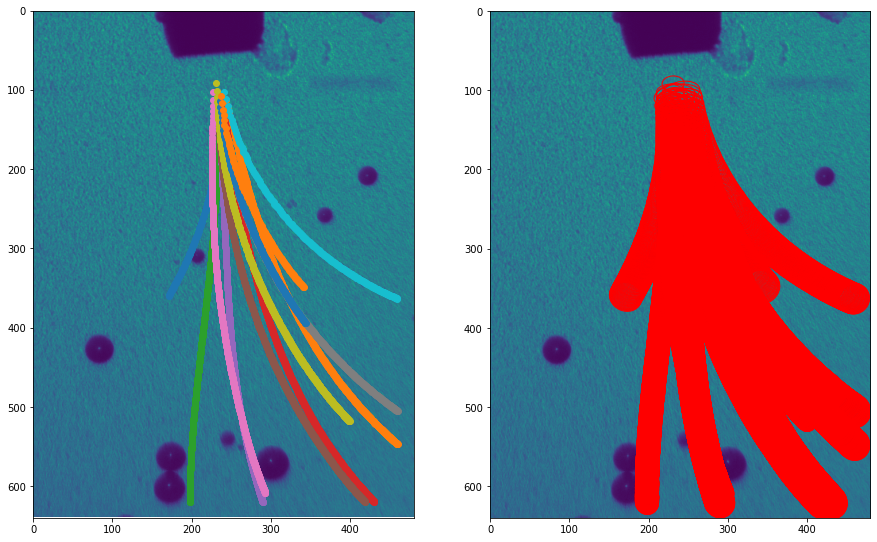

In [31]:
hp.plot_traj(traj,series)

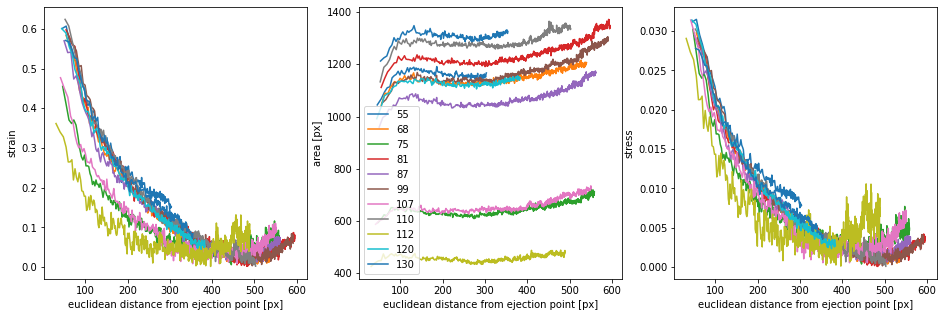

In [57]:
hp.plot(traj)

In [55]:
#remove manually particles which are still unfitting
traj = hp.removePar(traj,[135])

In [58]:
#if only good tracks --> save
csvPath = path.replace('tif','csv')
traj.to_csv(csvPath)

hp.write2cdb(cdb,traj,config)

# old code / archive

14.930935577033972 25.905290518060347 16.7323197332319
[ 0.07093548 54.19991252  0.63091548]


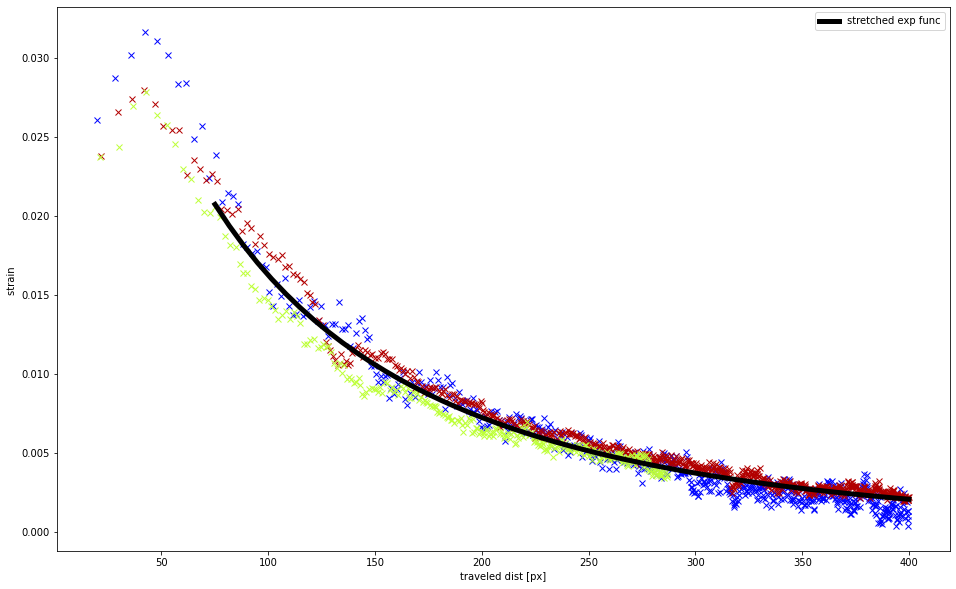

In [82]:
def linear(x,m,t):
    return x*m+t
def exp_stretched(t,a,tau,beta):
    return a*np.exp(-(t/tau)**beta)

#lowest and highest radius in detected objects
min_r = np.min(traj['radius'])
max_r = np.max(traj['radius'])
median_r = np.median(traj['radius'])
print(min_r,max_r,median_r)
#choose colormap
cmap = plt.get_cmap('jet')

fig,ax = plt.subplots(figsize=(16,10))

for par,d in traj.groupby('particle'):
    r = np.mean(d['radius'])
    color = int((r-min_r)/(max_r-min_r)*255)
    c = cmap(color)
    #if r > median_r:
    
    d = d[d['traveled_dist'] < 400]
    
    
    
    #ax.plot(d['traveled_dist'],d['strain'],label=str(par),color=c)
    ax.plot(d['traveled_dist'],d['strain']/d['radius'],'x',color=c,)
    #curves collapse if divided by radius

    #ax.plot(d['traveled_dist'],d['strain'],color=c)#,label=f'{par}')
    #ax.plot(d['traveled_dist'],d['guck_poly']/d['radius'],color='black')

    
    ax.set_xlabel('traveled dist [px]')
    ax.set_ylabel('strain ')
    #ax.set_ylim(0.4,0.8)
    
    #plt.semilogx()

#save traj data frame to csv file
#traj.to_csv(r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\traj_meter.csv')

#fit strechted exp function to data
mask = np.logical_and(traj['traveled_dist'] < 400,traj['traveled_dist'] > 75)
popt,pcov = curve_fit(exp_stretched,traj['traveled_dist'][mask],traj['strain'][mask]/traj['radius'][mask],p0=[0.05,100,0.4])
print(popt)
x_ = np.linspace(np.min(traj['traveled_dist'][mask]),np.max(traj['traveled_dist'][mask]))
plt.plot(x_,exp_stretched(x_,*popt),linewidth=5,color='black',label='stretched exp func')
plt.legend()
plt.show()



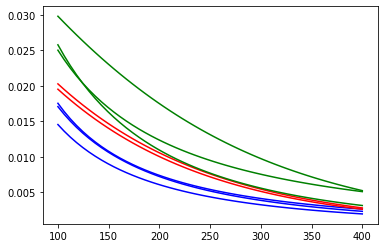

In [81]:
x_data = np.linspace(100,400)

a = [0.24510487, 8.82442446, 0.40379212]
plt.plot(x_data,exp_stretched(x_data,a[0],a[1],a[2]),color='blue')

a = [0.26536567 ,6.0264072 , 0.3795937 ]
plt.plot(x_data,exp_stretched(x_data,a[0],a[1],a[2]),color='blue')

a = [1.50423633, 0.29592114, 0.25647491]
plt.plot(x_data,exp_stretched(x_data,a[0],a[1],a[2]),color='blue')

a = [3.80069953e-02, 1.57052861e+02, 1.02696713e+00]
plt.plot(x_data,exp_stretched(x_data,a[0],a[1],a[2]),color='red')

a = [3.74592304e-02, 1.52312301e+02, 1.01538152e+00]
plt.plot(x_data,exp_stretched(x_data,a[0],a[1],a[2]),color='red')

a = [ 0.16569337, 32.08286634,  0.54638366]
plt.plot(x_data,exp_stretched(x_data,a[0],a[1],a[2]),color='green')

a = [4.53909041e-02 ,2.08126617e+02 ,1.17998699e+00]
plt.plot(x_data,exp_stretched(x_data,a[0],a[1],a[2]),color='green')

a = [0.39356773, 4.59122887 ,0.32904735]
plt.plot(x_data,exp_stretched(x_data,a[0],a[1],a[2]),color='green')

In [ ]:
#spheroids
path = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\01_07_22\1000_cell\analysed data_1000cells_01_07\video2\2022_07_01_16_44_17.tif'

df = hp.filterTime(df,t=(1176,1330))

#traj = assignOneParticleID(traj)
traj

In [51]:
#choose tiff file 

path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\250\2022_06_24_15_38_10.tif' #lot of bubbles 100pa
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\2000\2022_06_24_13_03_41.tif' #two single bubles, one spheroid
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\250\2022_06_24_15_36_20.tif' #debris output
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\2000\2022_06_24_13_05_18.tif' #only one spheroid
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\250\2022_06_24_15_30_40.tif'
#path_to_tif = r'‪\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\500\2022_06_24_16_36_08.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\500\2022_06_24_16_06_14.tif' #lot of bubbles2, 80pa
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\250\2022_06_24_15_43_52.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\new_camera\2022_07_01_15_55_32.tif' #only one spheroid new camera
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\01_07_22\1000_cell\2022_07_01_16_40_51.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\01_07_22\1000_cell\2022_07_01_16_45_55.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_25_12_34_23.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_19_12_05_36.tif' #tracking doesnt work
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_19_12_07_10.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_19_12_07_33.tif' #works well
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_25_12_34_14.tif' #works partly
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_25_12_34_23.tif' #filter more
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\80kPa\2022_07_25_12_38_47.tif' #better filtering
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\80kPa\2022_07_25_12_40_38.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\65kPa\2022_07_25_12_35_34.tif'
path_to_tif = r'‪\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\80kPa\2022_07_25_12_41_30.tif'
path_to_tif = path_to_tif.strip("‪u202a")
#create path to output video
head, tail = os.path.split(path_to_tif)
output_path = os.path.join(r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data',tail[:-3]+'mp4')
print(output_path)

\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\2022_07_25_12_41_30.mp4


# load the tif file

In [52]:
def load_tif(path):
    with tiff.TiffFile(path) as tif:
        series = [page.asarray() for page in tqdm(tif.pages[0:])]
        series = np.array(series)
        series = series.astype(np.uint8)
        series = cv2.normalize(series, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
    return series

series = load_tif(path_to_tif)
#normalize images to 8bit range[0,255] compatible with opencv
#
print(series.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2244/2244 [00:00<00:00, 8015.34it/s]


(2244, 640, 480)


# Extract ellipses

1298
Otsus threshold 46.0


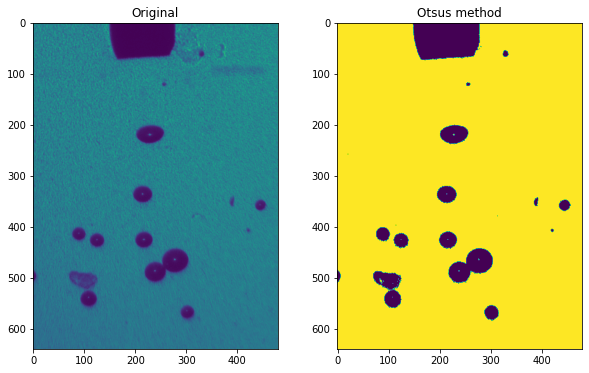

In [53]:
#choose random image from series
n = random.randint(0, len(series))
#n = 1194
print(n)
img = series[n]

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
axs[0].set_title('Original')
axs[0].imshow(img)

#normal thresholding on manually set threshold t=40
th, threshed = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

#axs[1].set_title('manual thres.')
#axs[1].imshow(threshed)
#adaptively chosen threshold by Otsu's method
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print('Otsus threshold',ret2)
axs[1].set_title('Otsus method')
axs[1].imshow(th2)

plt.show()



Text(0.5, 1.0, 'Triangle')

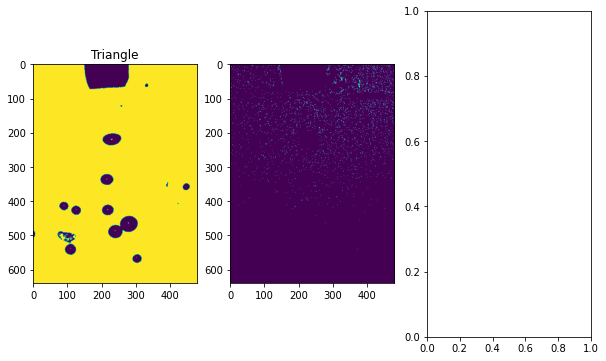

In [54]:
from skimage import data
from skimage import filters
from skimage.filters.thresholding import _cross_entropy
from skimage.filters import threshold_triangle

#try different thresholding techniques
img = series[n]
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(10,6))
axs[0].set_title('Li')

thresholds = np.arange(np.min(img) + 1.5, np.max(img) - 1.5)
entropies = [_cross_entropy(img, t) for t in thresholds]

optimal_img_threshold = thresholds[np.argmin(entropies)]

axs[0].imshow(img>optimal_img_threshold)


th_triangle = threshold_triangle(img, nbins = 50)
axs[1].imshow(img>th_triangle)
axs[0].set_title('Triangle')

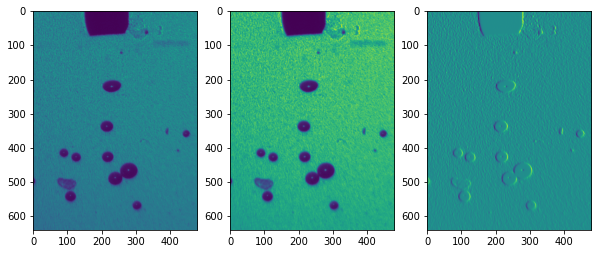

In [55]:
#try segmentation with canny-edge (work in progress)
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(10,6))
axs[0].imshow(img)
img_blur = cv2.GaussianBlur(img, (3,3), 0)
axs[1].imshow(img_blur)
def auto_canny(image, sigma=0.33):
        # compute the median of the single channel pixel intensities
        v = np.median(image)
        # apply automatic Canny edge detection using the computed median
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        edged = cv2.Canny(image, lower, upper)
        # return the edged image
        return edged
    
#edges = cv2.Canny(image=img_blur, threshold1=225, threshold2=250)
edges = auto_canny(img,sigma=0.4)
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge D
sobelx = cv2.normalize(sobelx, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)#
#axs[2].imshow(edges)
axs[2].imshow(sobelx)

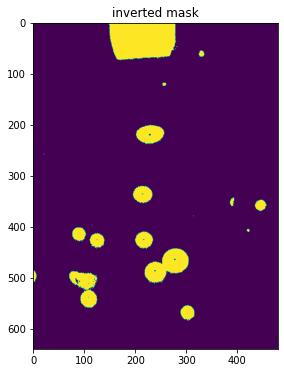

In [56]:
#invert the image and find contours
inv = 255 - th2
fig,ax=plt.subplots(figsize=(10,6))
ax.imshow(inv)
ax.set_title('inverted mask')

plt.show()  



130
width 54.0
width 130.0
214.0 74.0


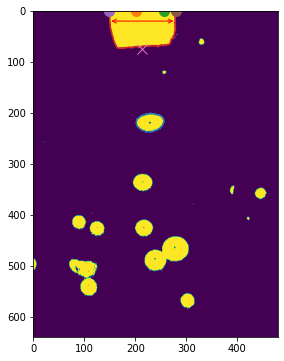

In [57]:
#get calibration: needle = 800mikron
#width of needle in px
w_needle_px = np.sum(inv[0,:] == 255)
print(w_needle_px)
factor = 800e-6/w_needle_px #um/px

fig,ax=plt.subplots(figsize=(10,6))
ax.imshow(inv)

cnts, hiers = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
for cnt in cnts:
    if len(cnt) > 40:
        contour = np.squeeze(cnt)
        polygon = Polygon(contour)
        x,y = polygon.exterior.xy
        y = np.array(y)
        x = np.array(x)
        if (y < 250).any():
            ax.plot(x,y)
            xl = np.min(x)
            ax.plot(xl, 0, marker="o", markersize=10)
            xr = np.max(x)
            ax.plot(xr, 0, marker="o", markersize=10)
            width = (xr - xl)
            print('width',width)
            ej_x = xr - width/2
            ej_y = np.max(y)
            
ax.plot(ej_x, ej_y, marker="x", markersize=10)
ax.annotate(
    '', xy=(xl, 20), xycoords='data',
    xytext=(xr, 20), textcoords='data',
    arrowprops={'arrowstyle': '<->','color':'red'})
print(ej_x,ej_y)

302.33050537109375 568.2747802734375 26.229446411132812 28.07538604736328 162.5682373046875
101.78804016113281 515.865234375 45.386417388916016 81.46669006347656 159.86196899414062
263.0540771484375 475.5578918457031 46.12731170654297 101.72412109375 60.6049919128418
125.1231460571289 427.1493835449219 27.241104125976562 28.16764259338379 117.5665283203125
217.09439086914062 426.1242370605469 31.839120864868164 33.41543197631836 87.27494049072266
89.58290100097656 414.6322937011719 25.308866500854492 26.677919387817383 143.69198608398438
445.4392395019531 358.1559753417969 20.237220764160156 21.142728805541992 54.45827865600586
214.5156707763672 336.82537841796875 32.45845413208008 37.15682601928711 93.58222198486328
228.8959197998047 219.1880645751953 35.23215103149414 53.94402313232422 84.73651123046875
329.74505615234375 61.54587936401367 9.7608060836792 11.765385627746582 176.51377868652344
214.0337677001953 28.322948455810547 94.2342758178711 140.24392700195312 85.5248031616211
56

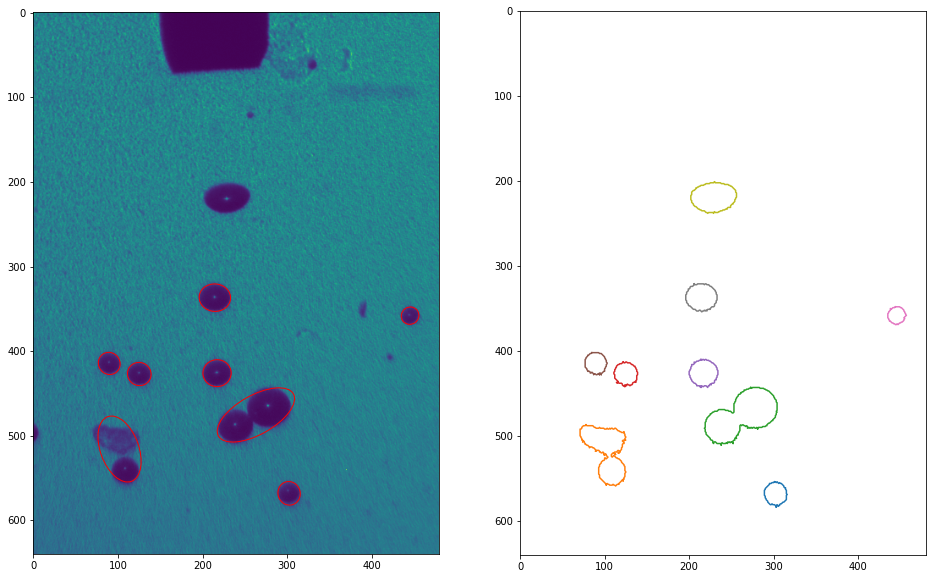

In [70]:
#using opencv to find contours of binary masks
'''
setting filters:
    - contour has to consist of minimum amount of pixel to fitler debris: min_px
    - fit ellipse to contour: ellipse has to have a min length: min_l
    - ellipse y coordinate has to be higher than output of needle tip: min_y
'''
min_px = 20
min_l = 20
min_y = 250

cnts, hiers = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]

ells = []
for cnt in cnts:
    if len(cnt) > min_px:
        ellipse = cv2.fitEllipse(cnt)
        x,y,l,s,p = ellipse[0][0],ellipse[0][1],ellipse[1][0],ellipse[1][1],ellipse[2]
        print(x,y,l,s,p)
        if l > min_l and y > min_y:
            ells.append([x,y,l,s,p])
            
fig,axs = plt.subplots(figsize=(16,10),ncols=2)

axs[0].imshow(img)
for e in ells:
    e = Ellipse(xy=(e[0],e[1]),width=e[2], height=e[3],angle=e[4])
    axs[0].add_artist(e)
    e.set_clip_box(axs[0].bbox)
    e.set_facecolor("none")
    e.set_edgecolor("red")

from shapely.geometry import Polygon
for cnt in cnts:
    if len(cnt) > min_px:
        contour = np.squeeze(cnt)
        polygon = Polygon(contour)
        x,y = polygon.exterior.xy
        if (np.array(y)>100).all():
            axs[1].plot(x,y)
            print(polygon.area)
axs[1].set_xlim(0,img.shape[1])
axs[1].set_ylim(img.shape[0],0)
plt.show()

# using trackpy to find trajectories

In [20]:
def find_objs(series):
    dic = {}
    frs,xs,ys,ls,ss,angles,area_poly,perimeter_poly = [],[],[],[],[],[],[],[]
    #loop over all images in series and extract ellipses
    for i in range(len(series)):
        img = series[i]
        #thresholding
        ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #inverting
        inv = 255 - th2
        #find contours
        cnts, hiers = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        for cnt in cnts:
            if len(cnt) > min_px:
                ellipse = cv2.fitEllipse(cnt)
                x,y,l,s,p = ellipse[0][0],ellipse[0][1],ellipse[1][0],ellipse[1][1],ellipse[2]
                if l > min_l and y > min_y:
                    frs.append(i)
                    xs.append(x)
                    ys.append(y)
                    ls.append(l)
                    ss.append(s)
                    angles.append(p)
                    
                    contour = np.squeeze(cnt) 
                    polygon = Polygon(contour)
                    area_poly.append(polygon.area)
                    perimeter_poly.append(polygon.length)
                    
    #save data into dictionary
    dic['frame'] = frs
    dic['x'] = xs
    dic['y'] = ys
    dic['l'] = ls
    dic['s'] = ss
    dic['angle'] = angles
    dic['area_poly'] = area_poly
    dic['perimeter_poly'] =perimeter_poly 
    df = pd.DataFrame(dic)
    return df

In [21]:
df = find_objs(series)

In [22]:
#find trajectories: tp.link adds column "particle" to df
'''
set parameters for trajectories
    - max_px: the maximum distance features can move between frames, optionally per dimension
    - memory: the maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle. 0 by default.
'''

def link(df,max_px = 300,memory = 0):
    traj = tp.link(df, max_px, memory=memory,pos_columns=['area_poly','y','x'])
    return traj

traj = link(df)
traj.head()

Frame 1500: 4 trajectories present.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
#define functions to calculate area, strain, deformation of ellipses

def area_ell(l,s):
    return np.pi * l  * s * 0.25

def perimeter_ell(l,s):
    a = l/2
    b = s/2
    return np.pi*(3*((a+b)/2)-np.sqrt(a*b))

def guck_deform(area,perimeter):
    c = 2*np.sqrt(np.pi*area)/perimeter
    d = 1-c
    return d

def strain(l,s):
    a = l/2
    b = s/2
    return (np.abs(a - b)) / np.sqrt(a * b)

#add traveled distance
def euclidean_dist(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [24]:
#find ejection point (#TODO), right now set manually
ej_point = (470,250)

def add_properties(traj):

    #add properties to pandas data frame
    traj['guck_def'] = guck_deform(area_ell(traj['l'],traj['s']),perimeter_ell(traj['l'],traj['s']))
    traj['guck_poly'] = guck_deform(traj['area_poly'],traj['perimeter_poly'])
    traj['strain'] = strain(traj['l'],traj['s'])
    traj['area_el'] = area_ell(traj['l'],traj['s'])
    traj['radius'] = np.sqrt(traj['area_el']/np.pi)
    
    #add properties in meter
    traj['radius_m'] = factor*traj['radius']
    traj['l_m'] = factor*traj['l']
    traj['s_m'] = factor*traj['s']
    traj['area_el_m'] = area_ell(traj['l_m'],traj['s_m'])
    
    #add traveled distance (in meter)
    traj['traveled_dist'] = euclidean_dist(traj['x'],traj['y'],ej_point[0],ej_point[1])
    traj['traveled_dist_m'] = factor*traj['traveled_dist'] 
    return traj
traj = add_properties(traj)

(640, 480)


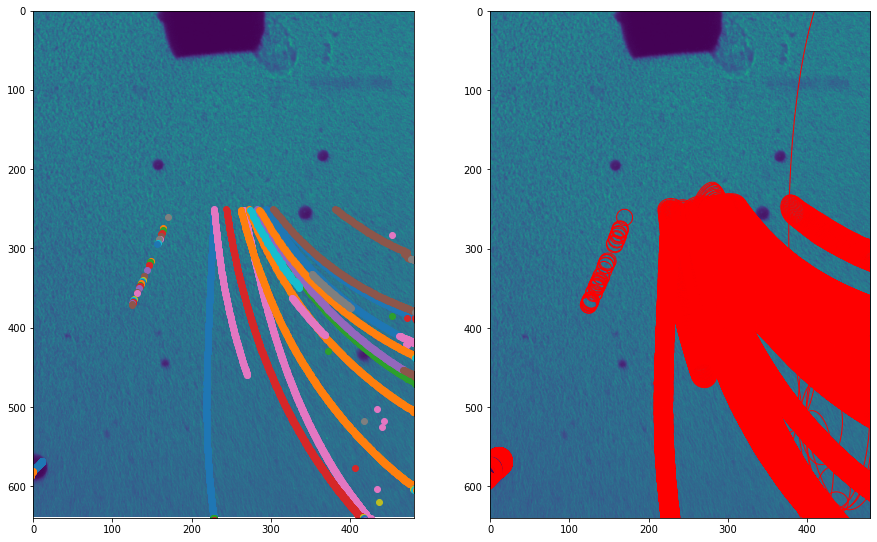

In [25]:
#filter trajectories

def filter_traj(traj,min_det=3,y0_min=250,y0_max=1000,y_last=1500,area_tol=0.5,y_max=1750,area_max=12000):
    '''
    min_det: minimum detections to count as trajectory
    y0_min/ y0_max: first detection has to be in this range
    #area_tol: area of detected object should not change more than tolarance 
    y_last hast to be higher than this value
    y_max: cut everthing off right before image ends
    '''

    #filter df that only reasonable tracks are in it
    remove = []
    remove_ind = []
    group = traj.groupby('particle')
    median_r = np.median(np.sqrt(traj['area_el']/np.pi))
    
    traj = traj[traj['y'] < y_max]

    for particle,g in group:
    
        #paticle should have at least min_det detections in trajectory, y-coord of first detection should be higher than y_0 and smaller than y0_max
        #last detection should be higher than 1500px to filter trajectories leaving image immediately
        if len(g) < min_det or g['y'].iloc[0] < y0_min or g['y'].iloc[0] > y0_max or g['y'].iloc[-1] < y_last:
            remove.append(particle)
        mode = float(stats.mode(g['area_poly'])[0])
        #area should not be bigger than 12000 px and area shouldnt change drasticly over time
        if (g['area_poly']>area_max).any() or (g['area_el'] < mode*(1-area_tol)).any() or (g['area_el'] > mode*(1+area_tol)).any():
            remove.append(particle)
        #bubble should not travel backwards
        if (g['traveled_dist'].sort_values(ascending=True).reset_index(drop=True) != g['traveled_dist'].reset_index(drop=True)).any():
            remove.append(particle)

    
    for r in remove:
        traj = traj.drop(traj[traj.particle == r].index)
    
    n_par = np.unique(traj['particle'])
    


    return traj

#traj = filter_traj(traj)

fig,axs = plt.subplots(figsize=(15,10),nrows=1,ncols=2)

print(series[n].shape)
axs[0].imshow(series[n])
axs[0].set_xlim(0, series.shape[2])
axs[0].set_ylim(series.shape[1], 0)

for par,d in traj.groupby('particle'):
    axs[0].scatter(d['x'],d['y'])    

axs[1].imshow(series[n])
m = traj['frame'] == n
ells = traj[m]
for index, row in traj.iterrows():
    e = Ellipse(xy=(row['x'],row['y']),width=row['l'], height=row['s'],angle=row['angle'])
    axs[1].add_artist(e)
    e.set_facecolor("none")
    e.set_edgecolor("red")
plt.show()


"\n#fit strechted exp function to data\npopt,pcov = curve_fit(exp_stretched,traj['traveled_dist'],traj['strain']/traj['radius'],p0=[0.05,100,0.4])\nprint(popt)\nx_ = np.linspace(np.min(traj['traveled_dist']),np.max(traj['traveled_dist']))\nplt.plot(x_,exp_stretched(x_,*popt),linewidth=5,color='black',label='stretched exp func')\nplt.legend()\nplt.show()\n"

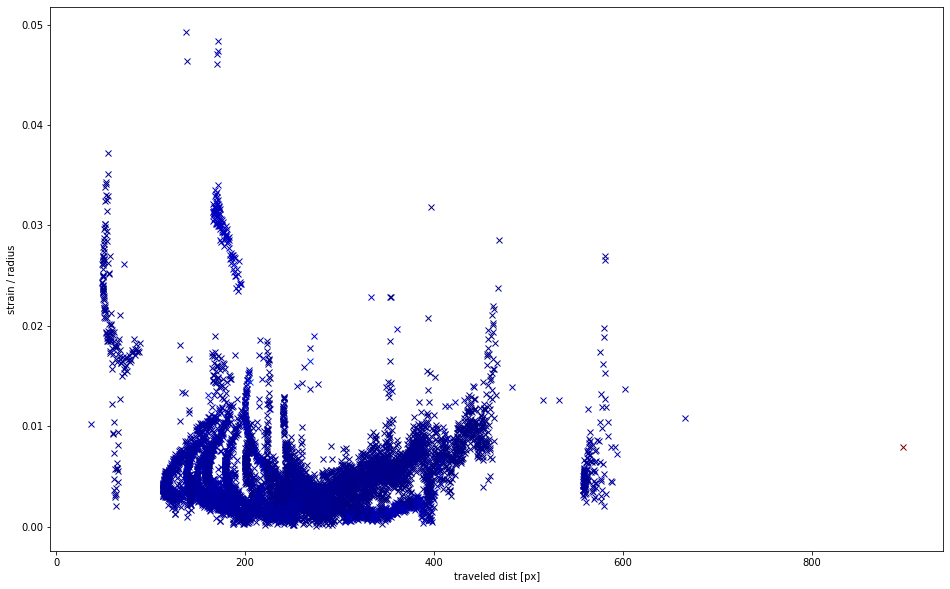

In [26]:
def linear(x,m,t):
    return x*m+t
def exp_stretched(t,a,tau,beta):
    return a*np.exp(-(t/tau)**beta)

#lowest and highest radius in detected objects
min_r = np.min(traj['radius'])
max_r = np.max(traj['radius'])
median_r = np.median(traj['radius'])

#choose colormap
cmap = plt.get_cmap('jet')

fig,ax = plt.subplots(figsize=(16,10))

for par,d in traj.groupby('particle'):
    r = np.mean(d['radius'])
    color = int((r-min_r)/(max_r-min_r)*255)
    c = cmap(color)
    #if r > median_r:
    
    #ax.plot(d['traveled_dist'],d['strain'],'x',color=c)
    ax.plot(d['traveled_dist'],d['strain']/d['radius'],'x',color=c,)
    #curves collapse if divided by radius

    #ax.plot(d['traveled_dist'],d['strain'],color=c)#,label=f'{par}')
    #ax.plot(d['traveled_dist'],d['guck_poly']/d['radius'],color='black')

    
    ax.set_xlabel('traveled dist [px]')
    ax.set_ylabel('strain / radius')
    
    #plt.semilogx()

#save traj data frame to csv file
traj.to_csv(r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\traj_meter.csv')
'''
#fit strechted exp function to data
popt,pcov = curve_fit(exp_stretched,traj['traveled_dist'],traj['strain']/traj['radius'],p0=[0.05,100,0.4])
print(popt)
x_ = np.linspace(np.min(traj['traveled_dist']),np.max(traj['traveled_dist']))
plt.plot(x_,exp_stretched(x_,*popt),linewidth=5,color='black',label='stretched exp func')
plt.legend()
plt.show()
'''

[ 2.01989416e-01  5.95703587e-09 -6.92549591e-01]


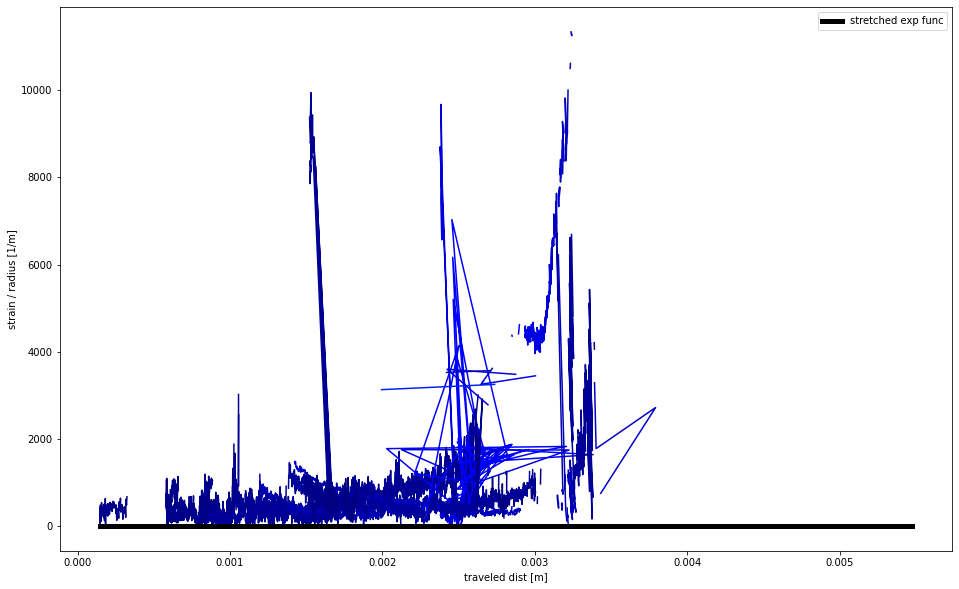

In [191]:
def linear(x,m,t):
    return x*m+t
def exp_stretched(t,a,tau,beta):
    return a*np.exp(-(t/tau)**beta)

#lowest and highest radius in detected objects
min_r = np.min(traj['radius_m'])
max_r = np.max(traj['radius_m'])

#choose colormap
cmap = plt.get_cmap('jet')

fig,ax = plt.subplots(figsize=(16,10))

for par,d in traj.groupby('particle'):
    r = np.mean(d['radius_m'])
    color = int((r-min_r)/(max_r-min_r)*255)
    c = cmap(color)
    
    #ax.plot(d['traveled_dist'],d['strain'],color=c)
    #curves collapse if divided by radius
    ax.plot(d['traveled_dist_m'],d['strain']/d['radius_m'],color=c)

    
    ax.set_xlabel('traveled dist [m]')
    ax.set_ylabel('strain / radius [1/m]')
    
    #plt.semilogx()

#save traj data frame to csv file
#traj.to_csv(r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\traj.csv')

#fit strechted exp function to data
popt_m,pcov = curve_fit(exp_stretched,traj['traveled_dist_m'],traj['strain']/traj['radius_m'],p0=[0.05,1e-3,0.4])
print(popt_m)
x_ = np.linspace(np.min(traj['traveled_dist_m']),np.max(traj['traveled_dist_m']))
plt.plot(x_,exp_stretched(x_,*popt_m),linewidth=5,color='black',label='stretched exp func')
plt.legend()
plt.show()

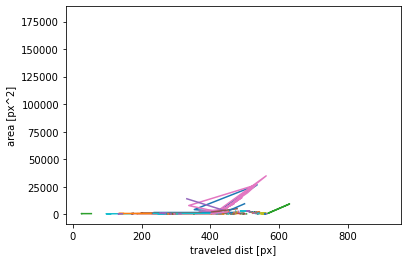

In [192]:
#check if area of ellipsoids stays constant
for par,d in traj.groupby('particle'):
    plt.plot(d['traveled_dist'],d['area_el'])
    #plt.plot(d['traveled_dist'],d['area_poly'])
    plt.xlabel('traveled dist [px]')
    plt.ylabel('area [px^2]')
plt.show()

In [ ]:
x_ = np.linspace(400,1800)


plt.plot(traj['traveled_dist'],traj['strain']/traj['radius'],'x')

popt,pcov = curve_fit(exp_stretched,traj['traveled_dist'],traj['strain']/traj['radius'],p0=[0.05,100,0.4])
x_ = np.linspace(400,1800)
plt.plot(x_,exp_stretched(x_,*popt))
plt.show()

In [ ]:
def linear_map(x,a,b,c,d):
    #map from interval [a,b] to interval [c,d]
    return c + ((d-c)/(b-a))*(x-a)


max_c = np.max(traj['guck_def'])
min_c = np.min(traj['guck_def'])

fig,ax = plt.subplots(figsize=(6,10))
for par,d in traj.groupby('particle'):
    c = linear_map(d['guck_def'],min_c,max_c,0,255)
    c = c.astype(int)
    c = cmap(c)
    ax.scatter(d['x'],d['y'],color=c)
    ax.plot(d['x'],d['y'])
ax.set_ylim(1920,0)

0.05307595745484463 N/m


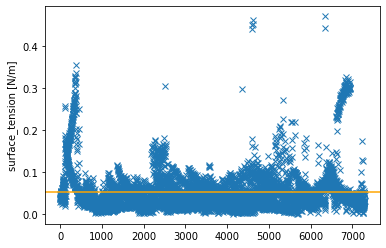

In [151]:
#calculate surface tension of spheroids
a,tau,beta = popt_m
gamma_s = traj['strain']/(traj['radius_m']*a/(72e-3)) * 1/(np.exp(-(traj['traveled_dist_m']/tau)**beta))

def const(x,a):
    return a

popt,pcov = curve_fit(const,np.arange(len(gamma_s)),gamma_s)
plt.plot(gamma_s,'x')
plt.ylabel('surface_tension [N/m]')
plt.axhline(popt,color='orange')
print(popt[0],'N/m')

Moviepy - Building video \\131.188.117.96\biophysDS2\jbartl\Spheriod_data\2022_07_25_12_35_34.mp4.
Moviepy - Writing video \\131.188.117.96\biophysDS2\jbartl\Spheriod_data\2022_07_25_12_35_34.mp4



TypeError: must be real number, not NoneType

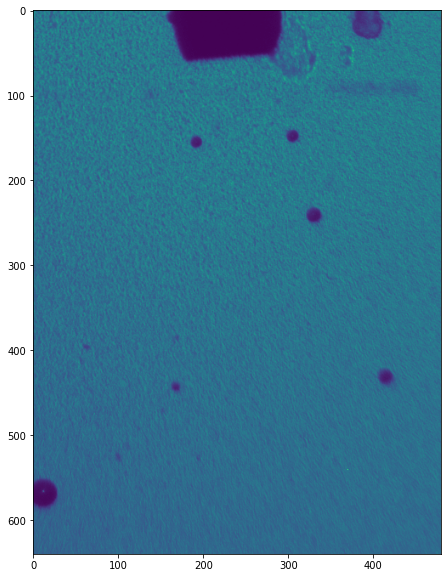

In [152]:
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
e
# duration of the video
#duration = 30

duration = len(series)/10
 
# matplot subplot
fig, ax = plt.subplots(figsize=(16,10))
 
# method to get frames
def make_frame(t):
    # clear
    ax.clear()
    t_ = int(10*t)
    # plotting line
    ax.imshow(series[t_])
    m = traj['frame'] == t_
    '''
    ells = traj[m]
    for index, row in ells.iterrows():
        e = Ellipse(xy=(row['x'],row['y']),width=row['l'], height=row['s'],angle=row['angle'])
        ax.add_artist(e)
        e.set_facecolor("none")
        e.set_edgecolor("red")
    ''' 
    # returning numpy image
    return mplfig_to_npimage(fig)
 
# creating animation
animation = VideoClip(make_frame, duration = duration)
 
# displaying animation with auto play and looping
#animation.ipython_display(fps = 20, loop = True, autoplay = True)
animation.write_videofile(output_path, fps=15) 

In [31]:
path_to_tif_s = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\new_camera\2022_07_01_15_55_32.tif' #one spheroid p=50Pa
series_s = load_tif(path_to_tif_s)
print(series_s.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:11<00:00, 209.45it/s]


(2500, 640, 480)


In [63]:
df_s = find_objs(series_s)
traj_s = link(df_s)
traj_s = add_properties(traj_s)
#traj_s = filter_traj(traj_s,min_det=3,y0_min=90,y0_max=400,y_last=400,area_tol=0.5,y_max=600,area_max=np.inf)
traj_s = traj_s[traj_s['y']<600]

Frame 2136: 1 trajectories present.


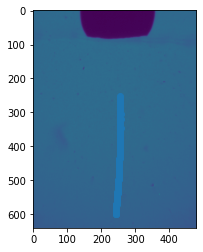

In [64]:
plt.imshow(series_s[0])
plt.scatter(traj_s['x'],traj_s['y'])

(0.0, 0.4)

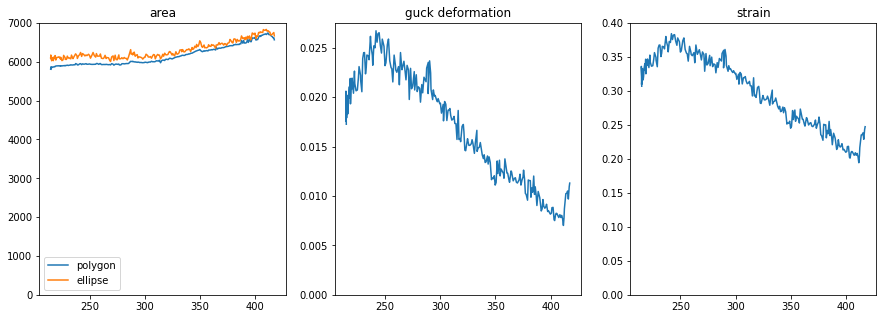

In [65]:
fig,axs = plt.subplots(ncols=3,figsize=(15,5))
axs[0].plot(traj_s['traveled_dist'],traj_s['area_poly'],label='polygon')
axs[0].plot(traj_s['traveled_dist'],traj_s['area_el'],label='ellipse')
axs[0].set_title('area')
axs[0].set_ylim(0,7000)
axs[0].legend()

axs[1].plot(traj_s['traveled_dist'],traj_s['guck_def'])
axs[1].set_title('guck deformation')
axs[1].set_ylim(0,0.0275)

axs[2].plot(traj_s['traveled_dist'],traj_s['strain'])
axs[2].set_title('strain')
axs[2].set_ylim(0,0.4)

# create video

# TODO
- overlapping bubbles or objects DONE filter them by checking area
- debris? DONE
- deformability over distance traveled DONE
- deformability over size (of bubbles) DONE
- strain of spheroids using polygons

In [ ]:
directory = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\01_07_22\1000_cell'
files = []
for file in os.listdir(directory):
    if file.endswith(".tif"):
        files.append(os.path.join(directory, file))
print(files[3])
# remove 2
series_s = load_tif(files[3])

df_s = find_objs(series_s)
print(df_s)
traj_s = link(df_s)
traj_s = add_properties(traj_s)
#traj_s = filter_traj(traj_s,min_det=3,y0_min=90,y0_max=400,y_last=400,area_tol=0.5,y_max=600,area_max=np.inf)
traj_s = traj_s[traj_s['y']<600]
plt.imshow(series_s[0])
plt.scatter(traj_s['x'],traj_s['y'])
plt.show()

fig,axs = plt.subplots(ncols=3,figsize=(15,5))
axs[0].plot(traj_s['traveled_dist'],traj_s['area_poly'],label='polygon')
axs[0].plot(traj_s['traveled_dist'],traj_s['area_el'],label='ellipse')
axs[0].set_title('area')
#axs[0].set_ylim(0,7000)
axs[0].legend()

axs[1].plot(traj_s['traveled_dist'],traj_s['guck_def'])
axs[1].set_title('guck deformation')
#axs[1].set_ylim(0,0.0275)

axs[2].plot(traj_s['traveled_dist'],traj_s['strain'])
axs[2].set_title('strain')
#axs[2].set_ylim(0,0.4)


In [128]:
a

5

In [6]:
mask = traj["frame"]==traj["frame"].unique()[0]
x0,y0,a0 = traj[mask][["x", "y", "area_poly"]].values.T

for frameId in traj["frame"].unique()[1:2]:
    mask = traj["frame"]==frameId
    if mask.sum()==0:
        continue
    x1,y1,a1 = traj[mask][["x", "y", "area_poly"]].values.T

NameError: name 'traj' is not defined

In [7]:
from scipy.optimize import linear_sum_assignment

In [8]:
eDist = ((x0[:,None]-x1[None,:])**2+(y0[:,None]-y1[None,:])**2)**0.5
eDist = ((x0[:,None]-x1[None,:])**2+(y0[:,None]-y1[None,:])**2+(a0[:,None]-a1[None,:])**2)**0.5
cost = -np.exp(-eDist) 
id0, id1 = linear_sum_assignment(cost)
print(id0, id1)

NameError: name 'x0' is not defined